In [1]:
import gensim
from gensim.models import doc2vec
from utils import read_jsonl, save_jsonl
from gensim.models.doc2vec import TaggedDocument
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
from pprint import pprint

In [2]:
load_file_path = './data/docs_jsonl_ma_komoran_after_processing.txt'

In [3]:
app_id_list, app_name_list, cate_list, rating_list, ma_list = read_jsonl(load_file_path)

Reading Files: 100%|██████████| 616311/616311 [00:24<00:00, 25335.57it/s]


major pos 만 골라보기

In [4]:
all_docs = []
docs_idx_list = []
featured_pos = ["NNG", "NNP", "NP", "MM", "MAG", "MAJ", "VV", "VA", "SL"]
verb_pos = ["VV", "VA"]

for i, doc in enumerate(ma_list):
    temp = [ma[0]+"다" if ma[1] in verb_pos else ma[0] if ma[1] in featured_pos else None for ma in doc]
    temp = [x for x in temp if x]
    if temp: #빈 문서는 제거
        all_docs.append(temp)
        docs_idx_list.append(i)

rating_list = list(np.array(rating_list)[docs_idx_list])
cate_list = list(np.array(cate_list)[docs_idx_list])

## 주제를 만들고 doc2vec으로 클러스터링 시도

In [5]:
print(list(set(cate_list)))

['사진 및 비디오', '생산성', '소셜 네트워킹', '카탈로그', 'NaN', '참고', '건강 및 피트니스', '스포츠', '의학', '여행', '교육', '뉴스', '날씨', '유틸리티', '도서', 'None', '게임', '잡지 및 신문', '비즈니스', '금융', '내비게이션', '음식 및 음료', '라이프 스타일', '음악', '엔터테인먼트']


특정 카테고리 뽑아보자: 사진 및 비디오

In [6]:
def get_specific_cate_data(docs, rating_list, cate_list, category, draw_rating_plot=True):
    idx_list = [i for i, cate in enumerate(cate_list) if cate == category]
    cate_docs = np.array(docs)[idx_list]
    cate_ratings = np.array(rating_list, dtype=np.int)[idx_list]
    if draw_rating_plot:
        sns.countplot(cate_ratings)
        plt.show()
        
    return idx_list, cate_docs, cate_ratings

def get_tagged_docs(cate_docs, tag_data=None):
    if tag_data:
        tagged_docs = [TaggedDocument(d, [t]) for i, t in zip(cate_docs, tag_data)]
    else:
        tagged_docs = [TaggedDocument(d, [i]) for i, d in enumerate(cate_docs)]
        return tagged_docs

def get_vector(docs, mode='tf-idf'):
    """mode= tf-idf or doc2vec"""
    if mode.lower() == 'tf-idf':
        dictionary = gensim.corpora.Dictionary(docs)
        corpus = [dictionary.doc2bow(doc) for doc in docs]
        tf_idf = gensim.models.TfidfModel(corpus)
        X_lda = tf_idf[corpus]   # tf_idf 로 바꿔줌 문서를 (단어idx, tf-idf값)
        
        return X_lda, tf_idf, corpus, dictionary
    
    elif mode.lower() == 'doc2vec':
        model = doc2vec.Doc2Vec(documents=docs, size=100, alpha=0.05, min_alpha=0.025,
                                window=5, min_count=3, workers=3, iter=10)        
        return model

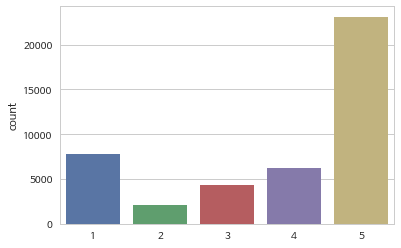

In [6]:
category = '사진 및 비디오'
idx_list, cate_docs, cate_ratings = get_specific_cate_data(all_docs, rating_list, cate_list, category)
X_lda, tf_idf, corpus, dictionary = get_vector(cate_docs, mode='tf-idf')
tagged_docs = get_tagged_docs(cate_docs)

In [8]:
n_topics = 5
n_words = 5
tfidf_model_path = './data/gensim_model/pic_video_reviews.lda'
doc2vec_model_path = './data/gensim_model/pic_video_reviews.doc2vec'

In [ ]:
lda = gensim.models.ldamodel.LdaModel(X_lda, num_topics=n_topics, id2word=dictionary)
model = get_vector(tagged_docs, mode='doc2vec')

In [ ]:
lda.save(tfidf_model_path)
model.save(doc2vec_model_path)

In [13]:
lda = gensim.models.ldamodel.LdaModel.load(tfidf_model_path)
model = doc2vec.Doc2Vec.load(doc2vec_model_path)
doc_vecs = model.docvecs

In [14]:
pprint(lda.print_topics(num_topics=n_topics, num_words=n_words))

[(0, '0.112*"좋다" + 0.028*"너무" + 0.022*"쓰다" + 0.021*"굳다" + 0.020*"예쁘다"'),
 (1, '0.089*"굿" + 0.019*"Good" + 0.014*"완전" + 0.012*"아날로그" + 0.010*"편리"'),
 (2, '0.094*"삭제" + 0.088*"구매" + 0.083*"부탁" + 0.080*"드리다" + 0.078*"내역"'),
 (3, '0.027*"결제" + 0.017*"되다" + 0.016*"환불" + 0.014*"하다" + 0.014*"안"'),
 (4, '0.018*"짱" + 0.015*"리뷰" + 0.013*"좋다" + 0.013*"사진" + 0.012*"찍다"')]


주제 갯수를 5~15개 별로 나눠서 시도 했는데 다들 비슷한 내용이다. 여러번 시도해서 그나마 좀 다른 주제 5개를 선택

topic에 라벨링을 하여 클러스터링 시도


In [7]:
def get_labels(lda, corpus, threshold):
    """문서가 어떤 주제에 속할 확률을 얻는다. 주제가 두 가지 이상일 수도 있다."""
    proba_list = lda[corpus]
    if isinstance(threshold, float):
        topic = [x for x in proba_list if x[1] >= threshold]
    else: 
        topic = [x for x in proba_list if x[1] == max([p for x, p in proba_list])]
    if len(topic) == 0:
        topic = None
    return topic

def get_topic_table(df, lda, corpus, threshold, duplicated=True):
    """각 문서마다 토픽을 달아준다"""
    len_topics, len_words = lda.get_topics().shape
    topic_labels_data = []
    for i in tqdm(range(len(corpus)), desc='processing...', total=len(corpus)):
        temp = get_labels(lda, corpus[i], threshold)
        if duplicated:
            if temp != None:
                temp_topic = [t[0] for t in temp]
                labels = [1 if i in temp_topic else 0 for i in range(len_topics+1)]
                topic_labels_data.append(labels)
            else:
                labels = [1 if i == len_topics else 0 for i in range(len_topics+1)]
                topic_labels_data.append(labels)
            topic_labels = [i for i in range(len_topics)] + ['unknown']
        else:
            if temp != None:
                topic_labels_data.append(temp[0][0])
            else:
                topic_labels_data.append(len_topics)
            topic_labels = ['topic_label']
    
    temp_df = pd.DataFrame(topic_labels_data, columns=topic_labels)
    df_ = pd.concat([df, temp_df], axis=1)
    return df_

In [24]:
df_cate = pd.DataFrame([' '.join(doc) for doc in cate_docs], columns=['reviews'])

In [25]:
df = get_topic_table(df=df_cate, lda=lda, corpus=corpus, threshold=None, duplicated=False)

processing...: 100%|██████████| 43559/43559 [00:32<00:00, 1324.33it/s]


In [26]:
df.tail()

,reviews,topic_label
43554,이 앱 정말 멋지다 별 아깝다 셀피 찍다 있다 타이머 있다 금상 첨,4
43555,현상 시간 있다 정말 중독 강하다 앱 일회용 카메라 사진 찍다 재미 흥분 재현 앱 추천,4
43556,환불,3
43557,사기 가짜 어플 알리다,3
43558,마음 들다 앱 필름 현상 위하다 동안 기다리다 하다 재미있다 신나다,0


In [27]:
# topic에 속한 문서 갯수
label, counts = np.unique(df['topic_label'].values, return_counts=True)
pd.Series(counts, index=label)

0     7149
1     4239
2     5603
3    13484
4    13084
dtype: int64

lda_vector 만들기 = doc2vec + lda_prob

In [28]:
print(cate_docs[0])
print(corpus[0])
lda[X_lda[0]]

['인터넷', '떠돌다', '초보', '편집', '프로', '그램', '훨씬', '좋다', '사진', '편집', '앱', '대량', '구매', '보다', '단연', '최고', '저', 'DSLR', '로', '찍다', '사진', '아이폰', '넣다', '이', '앱', '편집', '하다', '짱', '만들다', '감사합니다', '너무', '잘', '쓰다', '있다', '사진', '코멘트', '기능', '좀', '더', '넣다', '감사', '하다', '모든', '액자', '정', '있다', '액자', '없이', '텍스트', '넣다', '업데이트', '바래다']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 3), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 3), (18, 1), (19, 1), (20, 2), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 3), (39, 1), (40, 2), (41, 1)]


[(0, 0.03165139633425914),
 (1, 0.030219053126823121),
 (2, 0.082246782975892788),
 (3, 0.31630602676600039),
 (4, 0.53957674079702445)]

In [29]:
doc_vecs.doctag_syn0.shape

(43559, 100)

In [8]:
def get_lda_vecs(doc_vecs, lda, X_lda):
    len_docs = doc_vecs.doctag_syn0.shape[0]
    lda_vec = []
    for i in tqdm(range(len_docs), desc='processing', total=len_docs):
        lda_vec.append([prob for topic, prob in lda[X_lda[i]]])
    
    lda_vecs = np.hstack([doc_vecs.doctag_syn0, np.array(lda_vec)])
    return lda_vecs

In [29]:
lda_vecs = get_lda_vecs(doc_vecs, lda, X_lda)

processing: 100%|██████████| 43559/43559 [00:27<00:00, 1574.98it/s]


doc2vec 2차원에 표현(unknown 없고 최대 확률만 계산함)

In [9]:
def draw_2d_data(vecs, label_data, delete_uknown=False):
    label = np.unique(label_data)

    palette = sns.color_palette('husl', n_colors=len(label))
    palette_dict = {i:p for i, p in zip(range(len(label)), palette)}
    
    pca = PCA(n_components=2)
    pca.fit(vecs)
    pca_vecs = pca.transform(vecs)
    
    df_values = np.hstack([pca_vecs, label_data.values.reshape(-1, 1)])
    if delete_uknown:
        df_values = np.delete(df_values, [i for i, x in enumerate(df_values[:, -1]) \
                                          if x == n_topics], 0)
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    ax.scatter(df_values[:, 0], df_values[:, 1], c=[palette_dict[int(i)] for i in df_values[:, 2]],
                         s=40, edgecolors='black', alpha=0.8)
    
    patch_list = []
    for lb in label:
        c = mpatches.Circle((0.5, 0.5), 0.25, facecolor=palette_dict[lb], 
                            edgecolor='black', linewidth=0.5)
        patch_list.append(c)
    ax.legend(patch_list, label)
    plt.show()

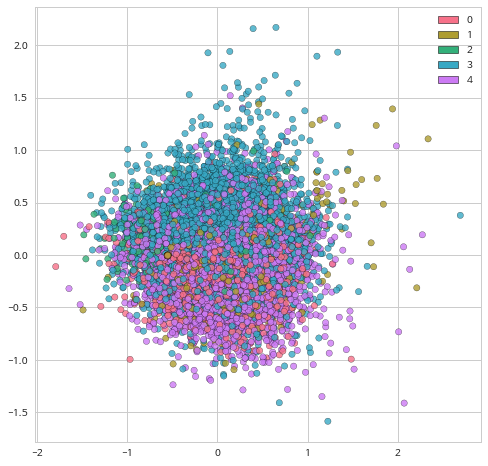

In [31]:
draw_2d_data(doc_vecs, df['topic_label'])

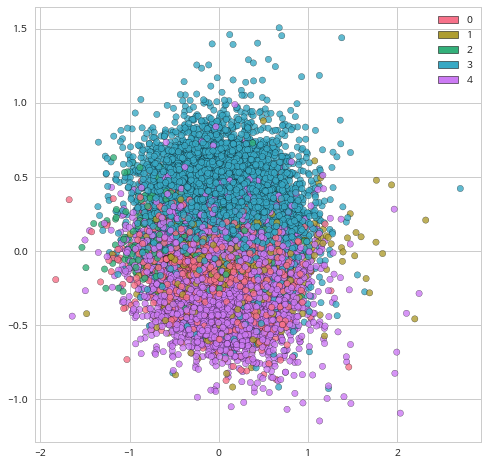

In [32]:
draw_2d_data(lda_vecs, df['topic_label'])

lda 관한 정보를 붙이니까 그림이 조금 달라졌다

## doc_vecs VS lda_vecs 클러스터링

In [33]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import k_means_, KMeans, MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from Clustering import get_cent_words

def euc2cos_distance(X, Y=None, Y_norm_squared=None, squared=False):
    return cosine_distances(X,Y)

In [34]:
# tf-idf
vectorizer = TfidfVectorizer(tokenizer=str.split)
tf_idf_matrix = vectorizer.fit_transform(df.reviews.values)
words = vectorizer.get_feature_names()

In [35]:
km_tf_idf = MiniBatchKMeans(n_clusters=n_topics, init='k-means++', max_iter=300, n_init=20, tol=0.0001)
km_tf_idf.fit(tf_idf_matrix.toarray())

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=300, max_no_improvement=10, n_clusters=5,
        n_init=20, random_state=None, reassignment_ratio=0.01, tol=0.0001,
        verbose=0)

In [36]:
get_cent_words(km_tf_idf, words, n_topics, 5)

,0,1,2,3,4
0,목록,삭제,구매,부탁,드리다
1,굿,좋다,뜨다,진짜,사진
2,좋다,쓰다,하다,안,사진
3,삭제,내역,구매,부탁,드리다
4,좋다,너무,편하다,정말,아주


In [37]:
pprint(lda.print_topics(num_topics=n_topics, num_words=n_words))

[(0, '0.112*"좋다" + 0.028*"너무" + 0.022*"쓰다" + 0.021*"굳다" + 0.020*"예쁘다"'),
 (1, '0.089*"굿" + 0.019*"Good" + 0.014*"완전" + 0.012*"아날로그" + 0.010*"편리"'),
 (2, '0.094*"삭제" + 0.088*"구매" + 0.083*"부탁" + 0.080*"드리다" + 0.078*"내역"'),
 (3, '0.027*"결제" + 0.017*"되다" + 0.016*"환불" + 0.014*"하다" + 0.014*"안"'),
 (4, '0.018*"짱" + 0.015*"리뷰" + 0.013*"좋다" + 0.013*"사진" + 0.012*"찍다"')]


그냥 tf-idf 로 클러스터링 한 것이 주제랑 비슷해 보인다

In [38]:
df['km_tf_idf_label'] = km_tf_idf.labels_

In [39]:
# doc2vec
k_means_.euclidean_distances = euc2cos_distance 

km = MiniBatchKMeans(n_clusters=n_topics, init='k-means++', max_iter=300, n_init=20, tol=0.0001)
km.fit(doc_vecs)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=300, max_no_improvement=10, n_clusters=5,
        n_init=20, random_state=None, reassignment_ratio=0.01, tol=0.0001,
        verbose=0)

In [40]:
df['km_label'] = km.labels_

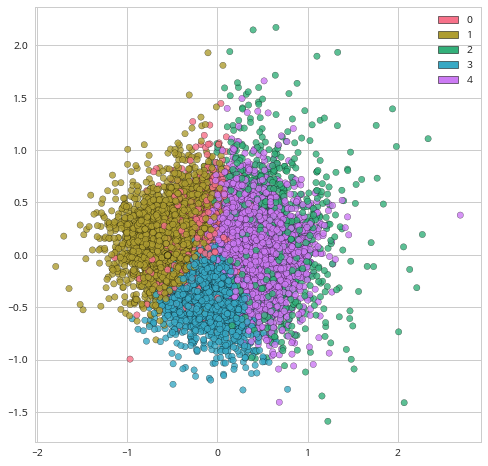

In [41]:
draw_2d_data(doc_vecs, df['km_label'])

In [42]:
# lda_vec
k_means_.euclidean_distances = euc2cos_distance 

km = MiniBatchKMeans(n_clusters=n_topics, init='k-means++', max_iter=300, n_init=20, tol=0.0001)
km.fit(lda_vecs)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=300, max_no_improvement=10, n_clusters=5,
        n_init=20, random_state=None, reassignment_ratio=0.01, tol=0.0001,
        verbose=0)

In [43]:
df['km_lda_label'] = km.labels_

In [44]:
# print("Silhouette Coefficient: %0.3f" % silhouette_score(lda_vecs, km.labels_))

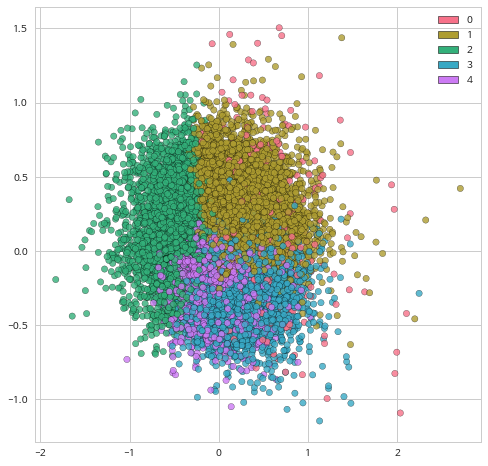

In [45]:
draw_2d_data(lda_vecs, df['km_lda_label'])

lda로 주제를 잡고 이를 doc2vec과 합쳐서 만든 vector로 클러스터링을 하였는데, Kmeans 알고리즘 하에서 썩 좋은 성능을 내진 않는다.

## 구매내역 삭제 리뷰 잡아내기
앱스토에어 보면 별 내용과 상관없이 "구매내역 삭제해주세요" 라는 리뷰들이 꽤 많다. 이를 한번 찾아보기로 한다.

In [46]:
lda.print_topics(n_topics, n_words)

[(0, '0.112*"좋다" + 0.028*"너무" + 0.022*"쓰다" + 0.021*"굳다" + 0.020*"예쁘다"'),
 (1, '0.089*"굿" + 0.019*"Good" + 0.014*"완전" + 0.012*"아날로그" + 0.010*"편리"'),
 (2, '0.094*"삭제" + 0.088*"구매" + 0.083*"부탁" + 0.080*"드리다" + 0.078*"내역"'),
 (3, '0.027*"결제" + 0.017*"되다" + 0.016*"환불" + 0.014*"하다" + 0.014*"안"'),
 (4, '0.018*"짱" + 0.015*"리뷰" + 0.013*"좋다" + 0.013*"사진" + 0.012*"찍다"')]

구매내역 삭제 리뷰는 토픽 2번에 해당된다.

In [47]:
mask = df.topic_label == 2

In [48]:
reviews = df.reviews[mask]
reviews.shape

(5603,)

리뷰중에 '구매', '내역', '삭제', '부탁', '드리다' 단어가 전부다 들어가면 제대로 분류 했다고 생각하고, count를 한다.

In [49]:
count = 0
query = '구매 내역 삭제 부탁 드리다'.split()
def check_word_in_doc(doc, query):
    x = 0
    for word in doc.split():
        if word in query:
            x += 1
    if x == 5:
        return True
        
for doc in reviews.values:
    if check_word_in_doc(doc, query):
        count += 1
print('accuracy = {}'.format(count / len(reviews)))

accuracy = 0.27074781367124756


In [57]:
reviews.head()

53                         w e
117    어플 잘 쓰다 있다 결제 처리 부탁 드리다
127                       kkkk
162                        존 유
163    ISO 시다 속 조리개 직접 조절 있다 맘
Name: reviews, dtype: object

doc2vec으로 찾아내는 것과 비교해보기

In [50]:
query = '구매 내역 삭제 부탁 드리다'.split()
query_vec = model.infer_vector(query)

In [63]:
sims = doc_vecs.most_similar([query_vec], topn=len(reviews))

In [64]:
total_sim_docs = []
for (doc_tag, sim) in sims:
    total_sim_docs.append([doc_tag, ' '.join(tagged_docs[doc_tag].words), sim])
df_doc2vec_reviews = pd.DataFrame(total_sim_docs, columns=['doc_tag', 'reviews', 'similarity'])

In [65]:
count = 0
for doc in df_doc2vec_reviews.reviews.values:
    if check_word_in_doc(doc, query):
        count += 1
print('accuracy = {}'.format(count / len(df_doc2vec_reviews)))

accuracy = 0.14742102445118688


In [66]:
df_doc2vec_reviews.head()

,doc_tag,reviews,similarity
0,27229,구매 내역 삭제 부탁 드리다,0.805158
1,34007,구매 내역 삭제 부탁 드리다,0.794768
2,26753,구매 내역 삭제 부탁 드리다,0.769340
3,41314,구매 내역 삭제 부탁 드리다,0.767799
4,24390,구매 목록 삭제 부탁 드리다,0.764854


In [67]:
df_sims = pd.DataFrame(np.vstack([df_doc2vec_reviews.reviews.values, reviews.values]).T, 
                       columns=['doc2vec', 'lda'])

In [68]:
df_sims.head(10)

,doc2vec,lda
0,구매 내역 삭제 부탁 드리다,w e
1,구매 내역 삭제 부탁 드리다,어플 잘 쓰다 있다 결제 처리 부탁 드리다
2,구매 내역 삭제 부탁 드리다,kkkk
3,구매 내역 삭제 부탁 드리다,존 유
4,구매 목록 삭제 부탁 드리다,ISO 시다 속 조리개 직접 조절 있다 맘
5,구매 내역 삭제 부탁 드리다,구매 내역 삭제 부탁 드리다
6,구매 내역 삭제 부탁 드리다,짱 짱
7,구매 내역 삭제 부탁 드리다,아이폰 용량 초과 구매 목록 삭제 요청
8,부탁 드리다,구매 내역 삭제 부탁 드리다
9,구매 내역 삭제 부탁 드리다,구매 내역 삭제 부탁 드리다


특정 주제가 있는 문서를 많이 찾을 때, lda로 특정 주제와 관련된 원하는 문서들을 찾고 doc2vec으로 확실하게 이를 걸러 내는 것이 좋을 것 같다.

만약에 찾고자 하는 주제의 문서를 몇 개만 검색하려면 doc2vec으로만 바로 검색하면 원하는 비슷한 문서를 찾을 수 있을 것 같다.


---

## 금융 카테고리 평점 분류

앱스토어 리뷰자 성향상 주로 5점을 많이 주기 때문에 그나마 부정적인 평가가 좀 있는 금융 카테고리를 보았다. 1점이 부정적이고 5점을 긍정적으로 주었다는 가정하에 진행한다

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

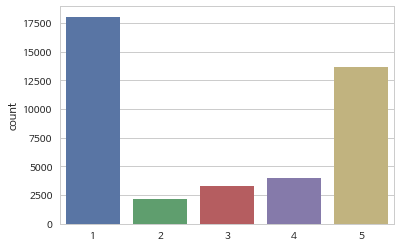

In [11]:
category = '금융'
idx_list, cate_docs, cate_ratings = get_specific_cate_data(all_docs, rating_list, cate_list, 
                                                           category)
tagged_docs = get_tagged_docs(cate_docs)

문서에서 1점과 5점문서를 12500개 씩 뽑아온다

In [12]:
def extract_docs(cate_docs, cate_ratings, n=12500):
    docs_1 = []
    docs_5 = []
    for r, doc in zip(cate_ratings, cate_docs):
        if r == 1:
            docs_1.append(doc)
        elif r == 5:
            docs_5.append(doc)
        else:
            pass
    
    return docs_1[:n], docs_5[:n]

In [13]:
docs_1, docs_5 = extract_docs(cate_docs, cate_ratings)

In [14]:
total_docs = docs_1 + docs_5
total_docs = get_tagged_docs(total_docs)
labels = [0 for i in range(len(docs_1))] + [1 for i in range(len(docs_5))]  # 부정 = 0, 긍정 = 1

In [16]:
len(total_docs), len(labels)  # 총 문서 갯수

(25000, 25000)

문서들을 대충 살펴보면

In [20]:
def get_docs_table(docs, labels):
    df = pd.DataFrame({'reviews': docs, 'labels': labels})
    return df

In [23]:
df_docs_1 = get_docs_table(docs_1, labels[:12500])
df_docs_5 = get_docs_table(docs_5, labels[12500:])
pd.concat((df_docs_1, df_docs_5), axis=1).head(10)

,labels,reviews,labels,reviews
0,0,"[한글, 지원, 공식, 안, 하다, 선언, 메일, 보내다, 물어보다, 크래쉬, 나서...",1,"[제, 아는, 한, 최고, 가계부, 시다, 자제, 기능, 원하다, 후회, 안]"
1,0,"[예전, 같다, 라이언, 스탑, 싱크, 아이폰, 어플, 계속, 튕기다, 어플, 먹,...",1,"[please, add, Korea, won, of, currency, option..."
2,0,"[We, are, want, won]",1,"[It, s, perfect, to, keep, record, of, my, car..."
3,0,"[리뷰, 좋다, 자꾸, 리뷰, 남기다, 팝업, 뜨다, 짜증, 나다, 이틀, 한번, ...",1,"[컴퓨터, 엑셀, 연계, 쓰다, 있다, 어플, 젤, 맘, 들다, 구글, 문서, 넣다..."
4,0,"[업데이트, 하다, 때, 거의 확실하게, 문제, 생기다, 같다, 평소, 문제, 이번...",1,"[카테고리, 기능, 좋다, 입력, 편하다, 입력, 자동, 환율, 계산, 입력, 전부..."
5,0,"[업데이트, 이후, 어플, 안, 열리다, 계속, 튕기다]",1,"[체계, 관리, 좋다, 같다]"
6,0,"[V, 로, 업, 이후, 항목, 지출, 금액, 입력, 후, 저장, 전체, 예산, 금...",1,"[제, 이, 앱, 구입, 이상, 쓰다, 꾸준히, 쓰다, 안, 앱, 이다, 수입, 지..."
7,0,"[이지모, 드, 밑, 자판, 올라오다, 회색, 화면, 멈추다, 아무런, 동작, 안,...",1,"[통장, 계좌, 잔액, 연동, 되다, 하다, 좋다]"
8,0,"[제, 원하다, 방식, 구매, 목록, 삭제]",1,"[요모조모, 자동, 반복, 불편]"
9,0,"[NPV, 해결, 좀, 하다, 오류, 자꾸, 뜨다, 해결, 환불, 시험, 시간, 쓰...",1,"[굿, 굿]"


대부분 우리가 생각하는 긍정 혹은 부정의 의미를 담는 리뷰가 남겨져 있다.

In [17]:
# train, test 분리
train_docs, test_docs, train_labels, test_labels = train_test_split(total_docs, labels)
print(len(train_docs), len(train_labels), len(test_docs), len(test_labels))

18750 18750 6250 6250


In [87]:
def get_doc2vec(docs):
    model = doc2vec.Doc2Vec(docs, size=100)
    doc_vecs = model.docvecs
    
    return doc_vecs

def build_doc_feat_mat(tagged_docs, doc_vecs):
    
    num_docs = len(tagged_docs)
    doc_feat_mats = np.zeros((num_docs, 100))
    
    for i, doc in enumerate(tagged_docs):
        doc_tag = doc.tags[0]
        doc_feat_mats[i] = doc_vecs[doc_tag]
        
    return doc_feat_mats

In [88]:
train_doc_vecs = get_doc2vec(train_docs)
test_doc_vecs = get_doc2vec(test_docs)
train_doc_feat_mats = build_doc_feat_mat(train_docs, train_doc_vecs)
test_doc_feat_mats = build_doc_feat_mat(test_docs, test_doc_vecs)

In [91]:
clf = LogisticRegression()
clf.fit(train_doc_feat_mats, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [93]:
pred_labels = clf.predict(test_doc_feat_mats)

In [94]:
accuracy = accuracy_score(test_labels, pred_labels)
print('Accuracy is {:.4f}'.format(accuracy))

Accuracy is 0.5613


### Navie Bayesian 비교

In [109]:
train_docs_NB = [' '.join(doc.words) for doc in train_docs]
test_docs_NB= [' '.join(doc.words) for doc in test_docs]

In [112]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

def NB_build_pipeline():
    pipeline = Pipeline([
                        ('vect', TfidfVectorizer(tokenizer=str.split)),
                        ('mb', MultinomialNB()),
                        ])
    return pipeline

In [113]:
pipeline = NB_build_pipeline()
pipeline.fit(train_docs_NB, train_labels)

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...True,
        vocabulary=None)), ('mb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [114]:
pred_labels_NB = pipeline.predict(test_docs_NB)

In [115]:
accuracy_NB = accuracy_score(test_labels, pred_labels_NB)
print('Accuracy is {:.4f}'.format(accuracy_NB))

Accuracy is 0.8802


역시나 나이브 베이지안이 훨씬 높다